In [2]:
# imports
import numpy as np
np.random.seed(1)

import pandas as pd
from tqdm.notebook import tqdm
import time
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

# IEOR 4500. Project 5. Pairs trading

In this project we address the basic elements of the pairs-trading strategy.

## Notation:
$p_i^t$ denotes the (closing) price of asset $i$ at time $t$.

The basic premise is as follows. Suppose that we consider a pair $(i,j)$ of assets. When we invest $S_k$ on this pair, we do the following:

- We take the position $S_k$ in asset $i$.
- We take the position $-S_k$ in asset $j$.

The worth of this position is judged as follows:

- The number of shares in asset $i$ equals $k/p_i^t$.
- The value of the position in asset $i$, at time $t+1$, equals $kp_i^{t+1}/p_i^t$.
- The value of the position in asset $j$, at time $t+1$, equals $-kp_j^{t+1}/p_j^t$.

Hence, if we close the pair position at time $t+1$, the value we accrue (gain or loss) equals
$$kp_i^{t+1}/p_i^t - kp_j^{t+1}/p_j^t.$$

Conceptually, you may have thought, throughout, that $k > 0$, i.e., we are longing $i$ and shorting $j$. However, make sure you understand that the formula is correct if $k < 0$, i.e., we short $i$ and long $j$.

- Denote
$$\Delta_i^t = p_i^{t+1}/p_i^t - p_j^{t+1}/p_j^t,$$
and
$$\bar{\Delta}_{ij} = \frac{1}{T} \sum_{t=0}^{T-1} \Delta_i^t.$$

The optimization problem we want to solve is:

Minimize
$$-\sum_{i<j} x_{ij}\Delta_{ij} + \theta \left( \frac{1}{T-1} \sum_{t=0}^{T-1} (\Delta_i^t - \bar{\Delta}_{ij})^2 \right)$$
(1a)

Subject to
$$-1 \leq x_{ij} \leq 1,$$
for all pairs $i < j$.
(1b)

Here, $\theta \geq 0$ is a risk-tolerance parameter. Your code should work for values of $\theta$ ranging from very small to large, e.g., $0 \leq \theta \leq 10^6$.

1. Implement a first-order method, using projected gradients, for this problem. Yes, you can also attempt to handle it using a solver, but I want to see the first-order implementation.

2. You should test it using the daily data that I have uploaded; Wilshire 5000 and Russell 1000. Using the first data set you should be able to get at least 3000 names with more than 1000 valid data values that are date-aligned.


In [3]:
# reading in data
data_folder = './data'
index_name = 'closeRussell1000'

# stuff that is used as input to the gradient descent function
stuff = dict()
file_endings = ['delta', 'delta_bar', 'delta_centered']
for end in file_endings:
    with open(f'./data/{index_name}_{end}.pkl', 'rb') as f:
        stuff[end] = pickle.load(f)

n, p = stuff['delta'].shape

with open(f'./data/{index_name}_pair_names.pkl', 'rb') as f:
    pair_names = pickle.load(f)

In [4]:
def get_batches(data: np.ndarray, batch_size: int) -> np.ndarray:
    '''Get random batch of size batch_size from data.'''
    n = data.shape[0]
    k = n // batch_size
    # shuffle the indices
    ind = list(range(n))
    np.random.shuffle(ind)
    # trimming the samples to a multiple of batch_size
    ind = ind[:k*batch_size]
    # yield a batch one by one
    for i in range(0, k, batch_size):
        yield data[ind[i: i+batch_size], :]

In [5]:
def f(x: np.ndarray, theta: float, pi: float, **kwargs) -> np.ndarray:
    '''Function which we intend to minimize. Vectorized.'''
    t = kwargs['delta_centered'].shape[0]
    return -np.dot(kwargs['delta_bar'], x) + theta/t * np.linalg.norm(kwargs['delta_centered'] @ x, pi)**pi

def g(x: np.ndarray, theta: float, pi: float, **kwargs) -> np.ndarray:
    '''Gradient of function f. Vectorized.'''
    t = kwargs['delta_centered'].shape[0]
    delta_centered_at_x = kwargs['delta_centered'] @ x
    return -kwargs['delta_bar'] + (theta / t * pi) * ((delta_centered_at_x**(pi-1)).T @ kwargs['delta_centered'])

def gradient_descent(x_0: np.ndarray, theta: float, pi: float, alpha: float, beta: float, \
                     num_iter: int, batch_size: int, tolerance: float, **kwargs) -> tuple:
    '''Gradient descent function. Using gradient normalization, momentum, clipping, and batches. Vectorized.'''
    converged = False
    x = y = x_0
    # evaluating function at initial value
    # seeing if we can minimize this!
    f_val = f(x=x_0, theta=theta, pi=pi, delta_bar=kwargs['delta_bar'], delta_centered=kwargs['delta_centered'])
    hist = [f_val]
    
    for iter in tqdm(range(num_iter), leave=True, desc='Iterations'):
        for batch in get_batches(data=kwargs['delta'], batch_size=batch_size):
            # computing gradient
            grad = g(x=x, theta=theta, pi=pi, delta_centered=kwargs['delta_centered'], delta_bar=kwargs['delta_bar'])
            # norming gradient: why?
            #   1) we are able to control the step-size purely with beta and 
            #       alpha without being influenced by varying magnitude of gradient
            #   2) we are able to eliminate "slow crawling" gradient descent and
            #       push out of flat regions of the surface faster
            grad /= np.linalg.norm(grad)
            # computing next step using momentum
            y = beta*y + (1-beta)*grad
            # clipping the gradient to enforce the problem's constraint
            x = np.clip(x - alpha*y, -1, 1)
            # evaluating new function value
            f_new = f(x=x, theta=theta, pi=pi, delta_bar=kwargs['delta_bar'], delta_centered=kwargs['delta_centered'])
            hist.append(f_new)
            # checking convergence
            if f_val - f_new < tolerance:
                converged = True
                break
            # new function value is the old function value in the next iteration
            f_val = f_new
        
    # returning tuple of
    #   bool: did we converge?
    #   np.ndarray: our portfolio positions at optimality
    #   list: function value at each step of gradient descent
    return converged, x, hist

In [9]:
# initial feasible guess
x_0 = np.random.uniform(-1, 1, p)
# utility function parameters
theta, pi = 10, 2

converged, x, hist = gradient_descent(
        x_0=x_0,
        theta=theta, pi=pi, alpha=1e-3, beta=0.9,
        num_iter=10, batch_size=32, tolerance=1e-6,
        **stuff
    )

Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

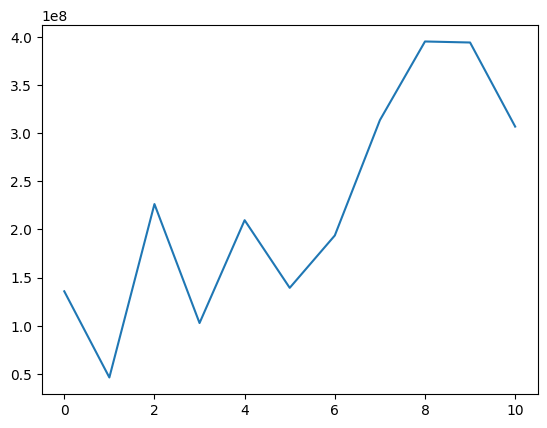

In [15]:
# plotting history, should be going down
plt.plot(hist)

In [14]:
# looking at resulting positions
pd.DataFrame({'pair_names': pair_names, 'position': x})

,pair_names,position
0,AOS-A,-1.0
1,AAL-A,1.0
2,AAP-A,-1.0
3,AAPL-A,1.0
4,ABBV-A,1.0
...,...,...
459356,ZNGA-ZG,-1.0
459357,ZTS-ZG,1.0
459358,ZNGA-ZION,1.0
459359,ZTS-ZION,1.0
